In [29]:
import pandas as pd
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Load the dataset (ensure correct path format)
df = pd.read_csv("D:/data/arr/arrhythmia.data", header=None, na_values="?")

# Display first few rows
print(df.head())

   0    1    2    3    4    5    6    7    8    9    ...  270   271  272  273  \
0   75    0  190   80   91  193  371  174  121  -16  ...  0.0   9.0 -0.9  0.0   
1   56    1  165   64   81  174  401  149   39   25  ...  0.0   8.5  0.0  0.0   
2   54    0  172   95  138  163  386  185  102   96  ...  0.0   9.5 -2.4  0.0   
3   55    0  175   94  100  202  380  179  143   28  ...  0.0  12.2 -2.2  0.0   
4   75    0  190   80   88  181  360  177  103  -16  ...  0.0  13.1 -3.6  0.0   

   274  275  276   277   278  279  
0  0.0  0.9  2.9  23.3  49.4    8  
1  0.0  0.2  2.1  20.4  38.8    6  
2  0.0  0.3  3.4  12.3  49.0   10  
3  0.0  0.4  2.6  34.6  61.6    1  
4  0.0 -0.1  3.9  25.4  62.8    7  

[5 rows x 280 columns]


In [2]:
# Explicit feature names as per arrhythmia.names
explicit_features = [
    "Age", "Sex", "Height", "Weight", "QRS duration", "P-R interval", "Q-T interval", 
    "T interval", "P interval", "QRS angle", "T angle", "P angle", "QRST angle", "J angle", 
    "Heart rate"
]

# ECG signal width attributes (DI, DII, ..., V6) - Channels
ecg_wave_features = [f"ECG_{i}" for i in range(16, 280)]  # 16 to 278 (corrected range)

# Combine all feature names
feature_names = explicit_features + ecg_wave_features + ["Class"]

# Verify column count before assignment
if len(feature_names) == df.shape[1]:
    df.columns = feature_names
else:
    print(f"Warning: Mismatch in column count! Expected {len(feature_names)}, found {df.shape[1]}.")


In [3]:
# Check for missing values
missing_values = df.isnull().sum().sum()
print(f"Total missing values: {missing_values}")

Total missing values: 408


In [4]:
df.head()

,Age,Sex,Height,Weight,QRS duration,P-R interval,Q-T interval,T interval,P interval,QRS angle,...,ECG_271,ECG_272,ECG_273,ECG_274,ECG_275,ECG_276,ECG_277,ECG_278,ECG_279,Class
0,75,0,190,80,91,193,371,174,121,-16,...,0.0,9.0,-0.9,0.0,0.0,0.9,2.9,23.3,49.4,8
1,56,1,165,64,81,174,401,149,39,25,...,0.0,8.5,0.0,0.0,0.0,0.2,2.1,20.4,38.8,6
2,54,0,172,95,138,163,386,185,102,96,...,0.0,9.5,-2.4,0.0,0.0,0.3,3.4,12.3,49.0,10
3,55,0,175,94,100,202,380,179,143,28,...,0.0,12.2,-2.2,0.0,0.0,0.4,2.6,34.6,61.6,1
4,75,0,190,80,88,181,360,177,103,-16,...,0.0,13.1,-3.6,0.0,0.0,-0.1,3.9,25.4,62.8,7


In [6]:
print(df["Class"].value_counts())#class value counts


Class
1     245
10     50
2      44
6      25
16     22
3      15
4      15
5      13
9       9
15      5
14      4
7       3
8       2
Name: count, dtype: int64


In [7]:
df.fillna(df.median(), inplace=True)  # Replace missing values with median


In [8]:
df.isnull().sum().sum()

0

In [9]:
print(df["Class"].value_counts())#class value counts



Class
1     245
10     50
2      44
6      25
16     22
3      15
4      15
5      13
9       9
15      5
14      4
7       3
8       2
Name: count, dtype: int64


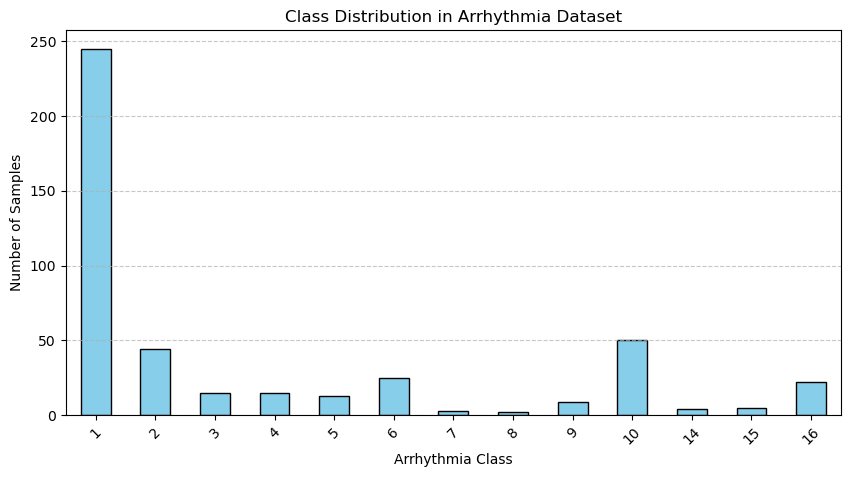

In [10]:
import matplotlib.pyplot as plt

df["Class"].value_counts().sort_index().plot(kind="bar", figsize=(10,5), color="skyblue", edgecolor="black")
plt.xlabel("Arrhythmia Class")
plt.ylabel("Number of Samples")
plt.title("Class Distribution in Arrhythmia Dataset")
plt.xticks(rotation=45)
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()


In [19]:
from imblearn.over_sampling import RandomOverSampler
X = df.drop(columns=["Class"])
y = df["Class"]

oversampler = RandomOverSampler(random_state=42)
X_resampled, y_resampled = oversampler.fit_resample(X, y)

df_resampled = pd.DataFrame(X_resampled, columns=df.columns[:-1])
df_resampled["Class"] = y_resampled

print(df_resampled["Class"].value_counts())


Class
8     245
6     245
10    245
1     245
7     245
14    245
3     245
16    245
2     245
4     245
5     245
9     245
15    245
Name: count, dtype: int64


C:\Users\syeds\AppData\Local\Temp\ipykernel_15168\1525102221.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_resampled["Class"] = y_resampled


In [20]:
import numpy as np
import pandas as pd
from sklearn.neighbors import NearestNeighbors

# Function to generate synthetic data using nearest neighbor interpolation
def generate_synthetic_data(existing_data, num_samples):
    #Generate synthetic samples by interpolating between real data points.
    nn = NearestNeighbors(n_neighbors=min(5, len(existing_data)))  # Ensure at least 2 neighbors
    nn.fit(existing_data)

    synthetic_samples = []
    for _ in range(num_samples):
        idx1, idx2 = np.random.choice(len(existing_data), 2, replace=False)
        sample = (existing_data.iloc[idx1] + existing_data.iloc[idx2]) / 2  # Linear interpolation
        synthetic_samples.append(sample)

    return pd.DataFrame(synthetic_samples, columns=existing_data.columns)

# Reference dataset with all existing classes
existing_classes = df["Class"].unique()
target_classes = list(range(1, 17))  # Classes 1 to 16 should all have 245 samples

# Create a list to store the final dataset
balanced_data = []

for class_label in target_classes:
    class_data = df[df["Class"] == class_label]  # Get existing data for the class
    
    if len(class_data) == 0:  # If class is missing, generate synthetic samples
        print(f"Generating synthetic data for Class {class_label}")
        synthetic_df = generate_synthetic_data(df.drop(columns=["Class"]), 245)
        synthetic_df["Class"] = class_label
        balanced_data.append(synthetic_df)
    
    elif len(class_data) < 245:  # If the class has fewer than 245 samples, oversample
        print(f"Oversampling Class {class_label}")
        resampled_data = class_data.sample(n=245, replace=True, random_state=42)
        balanced_data.append(resampled_data)
    
    else:  # If the class already has 245 samples, keep it unchanged
        balanced_data.append(class_data)

# Combine all balanced classes
df_balanced = pd.concat(balanced_data, ignore_index=True)

# Verify the final class distribution
print(df_balanced["Class"].value_counts().sort_index())


Oversampling Class 2
Oversampling Class 3
Oversampling Class 4
Oversampling Class 5
Oversampling Class 6
Oversampling Class 7
Oversampling Class 8
Oversampling Class 9
Oversampling Class 10
Generating synthetic data for Class 11
Generating synthetic data for Class 12
Generating synthetic data for Class 13
Oversampling Class 14
Oversampling Class 15
Oversampling Class 16
Class
1     245
2     245
3     245
4     245
5     245
6     245
7     245
8     245
9     245
10    245
11    245
12    245
13    245
14    245
15    245
16    245
Name: count, dtype: int64


In [21]:
df_balanced.shape

(3920, 280)

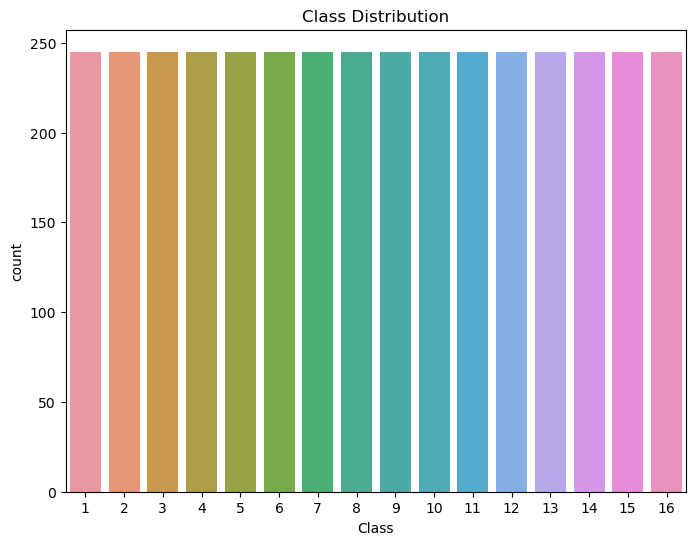

In [22]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
sns.countplot(x="Class", data=df_balanced)
plt.title("Class Distribution")
plt.show()


In [23]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif

# Apply SelectKBest to select the top 20 features
selector = SelectKBest(f_classif, k=20)  # Select top 10 features
X_new = selector.fit_transform(X, y)

# Get the selected feature names
selected_features = X.columns[selector.get_support()]

# Print the selected features
print("Selected features:", selected_features)


Selected features: Index(['QRS duration', 'Heart rate', 'ECG_17', 'ECG_91', 'ECG_100', 'ECG_112',
       'ECG_113', 'ECG_114', 'ECG_124', 'ECG_137', 'ECG_149', 'ECG_197',
       'ECG_220', 'ECG_228', 'ECG_230', 'ECG_238', 'ECG_240', 'ECG_241',
       'ECG_248', 'ECG_251'],
      dtype='object')


C:\Users\syeds\anaconda3\Lib\site-packages\sklearn\feature_selection\_univariate_selection.py:112: UserWarning: Features [ 19  67  69  83 131 132 139 141 143 145 151 156 157 164 204 264 274] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
C:\Users\syeds\anaconda3\Lib\site-packages\sklearn\feature_selection\_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


In [24]:
# Ensure column names are correctly selected and matched
selected_features= ['QRS duration', 'Heart rate', 'ECG_17', 'ECG_91', 'ECG_100', 'ECG_112',
       'ECG_113', 'ECG_114', 'ECG_124', 'ECG_137', 'ECG_149', 'ECG_197',
       'ECG_220', 'ECG_228', 'ECG_230', 'ECG_238', 'ECG_240', 'ECG_241',
       'ECG_248', 'ECG_251']

# Create a new DataFrame with selected features and the target variable
df_selected = df_balanced[selected_features + ['Class']]

# Display the first few rows of the new DataFrame to confirm
df_selected.head()


,QRS duration,Heart rate,ECG_17,ECG_91,ECG_100,ECG_112,ECG_113,ECG_114,ECG_124,ECG_137,...,ECG_197,ECG_220,ECG_228,ECG_230,ECG_238,ECG_240,ECG_241,ECG_248,ECG_251,Class
0,100.0,71.0,72.0,0.0,0.0,0.0,52.0,40.0,0.0,60.0,...,-1.7,1.6,-18.2,2.1,-12.7,0.7,0.0,7.6,0.0,1
1,77.0,70.0,44.0,0.0,0.0,0.0,36.0,48.0,0.0,40.0,...,-0.9,1.3,-30.9,1.7,-46.3,1.1,0.0,-19.8,0.0,1
2,78.0,67.0,44.0,0.0,0.0,0.0,36.0,44.0,0.0,48.0,...,-0.8,0.7,-15.5,0.9,-20.5,0.8,0.0,-16.1,0.0,1
3,84.0,64.0,40.0,0.0,0.0,0.0,28.0,44.0,0.0,44.0,...,-1.9,0.5,-14.5,0.7,-13.9,1.5,0.0,-19.3,0.0,1
4,77.0,72.0,40.0,0.0,0.0,0.0,40.0,48.0,0.0,40.0,...,-1.8,0.1,-9.0,0.1,-10.1,0.0,0.0,-8.8,0.0,1


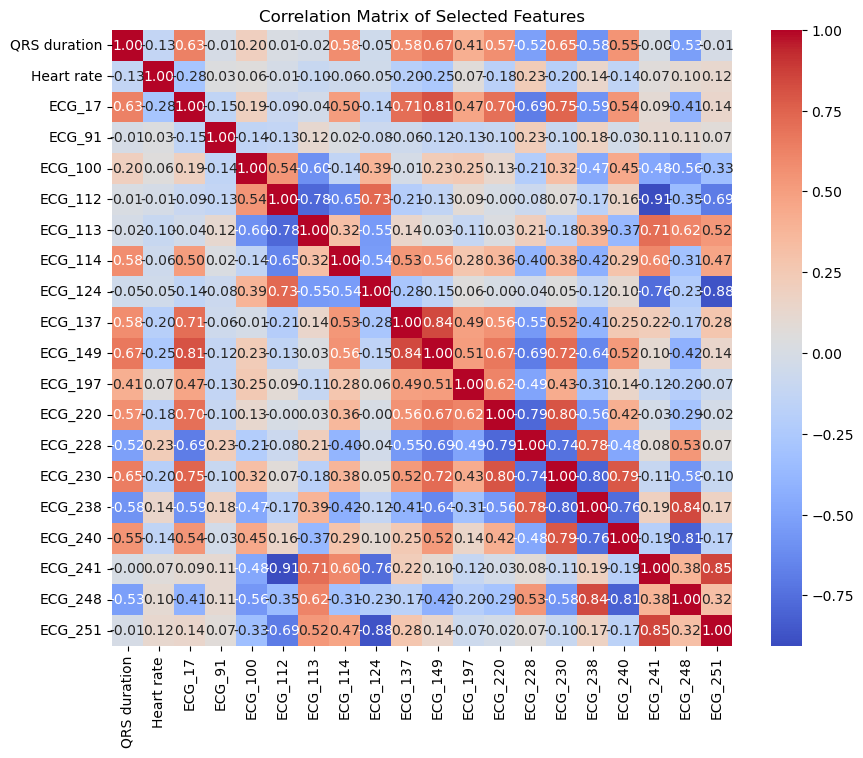

In [25]:
#corr
# Calculate the correlation matrix for the selected features
corr_matrix = df_selected.drop(columns=["Class"]).corr()

# Plot the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f", cbar=True)
plt.title("Correlation Matrix of Selected Features")
plt.show()


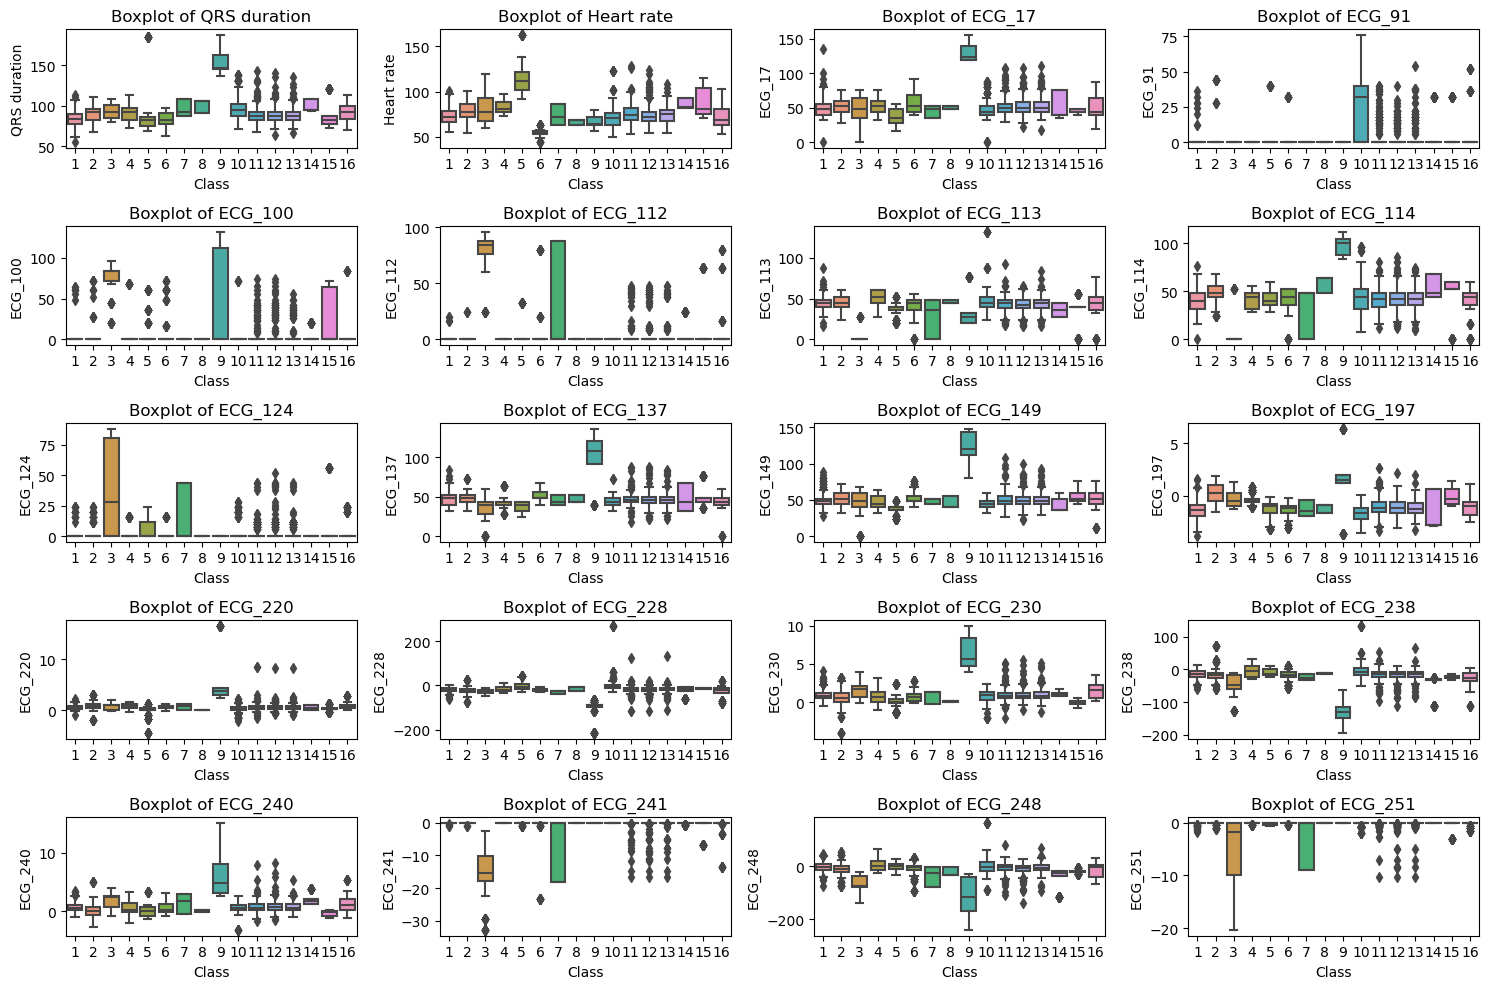

In [26]:
# Boxplot for each feature
plt.figure(figsize=(15, 10))
for i, feature in enumerate(selected_features):
    plt.subplot(5, 4, i+1)  # 5 rows, 4 columns
    sns.boxplot(data=df_selected, x='Class', y=feature)
    plt.title(f"Boxplot of {feature}")
plt.tight_layout()
plt.show()


In [27]:
from sklearn.model_selection import train_test_split
X = df_selected.drop(columns=["Class"])
y = df_selected["Class"]
X_train, X_test, y_train, y_test = train_test_split(X,y , test_size= 0.2, random_state=101)

In [28]:
print(X.shape)
print(y.shape)

(3920, 20)
(3920,)


Classification Report:
               precision    recall  f1-score   support

           1       0.51      0.56      0.53        55
           2       0.91      1.00      0.95        42
           3       1.00      1.00      1.00        43
           4       1.00      1.00      1.00        56
           5       0.98      1.00      0.99        49
           6       0.94      1.00      0.97        58
           7       1.00      1.00      1.00        43
           8       1.00      1.00      1.00        44
           9       1.00      1.00      1.00        36
          10       0.91      1.00      0.95        51
          11       0.11      0.11      0.11        46
          12       0.23      0.23      0.23        48
          13       0.33      0.22      0.26        64
          14       1.00      1.00      1.00        56
          15       1.00      1.00      1.00        48
          16       0.98      1.00      0.99        45

    accuracy                           0.81       784
  

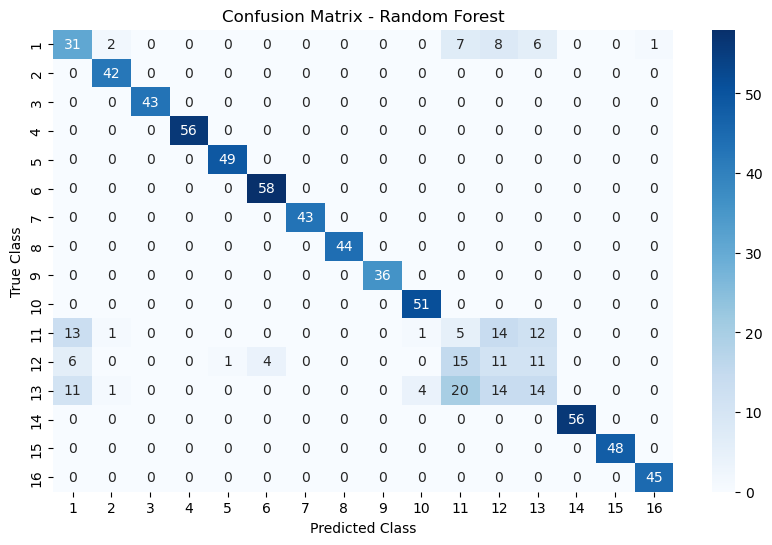

Cross-validation Accuracy Scores: [0.83290816 0.82397959 0.8125     0.82397959 0.82015306]
Mean Cross-validation Accuracy: 0.8227040816326531


In [31]:
# Create a ColumnTransformer for preprocessing
preprocessor = ColumnTransformer(
    transformers=[
        ('scaler', StandardScaler(), X.columns)
    ]
)

# Create a pipeline with preprocessing and RandomForestClassifier
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(n_estimators=100, random_state=42))
])

# Train the model using the pipeline
pipeline.fit(X_train, y_train)

# Make predictions
y_pred = pipeline.predict(X_test)

# Evaluate the model
print("Classification Report:\n", classification_report(y_test, y_pred))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap='Blues', xticklabels=y.unique(), yticklabels=y.unique())
plt.title("Confusion Matrix - Random Forest")
plt.xlabel("Predicted Class")
plt.ylabel("True Class")
plt.show()

# Cross-validation to assess model generalization
cv_scores = cross_val_score(pipeline, X, y, cv=5, scoring='accuracy')
print(f"Cross-validation Accuracy Scores: {cv_scores}")
print(f"Mean Cross-validation Accuracy: {cv_scores.mean()}")


Best Parameters from GridSearchCV: {'classifier__max_depth': 20, 'classifier__min_samples_split': 5, 'classifier__n_estimators': 100}
Best Model Classification Report:
               precision    recall  f1-score   support

           1       0.50      0.58      0.54        55
           2       0.89      1.00      0.94        42
           3       1.00      1.00      1.00        43
           4       0.98      1.00      0.99        56
           5       0.98      1.00      0.99        49
           6       0.94      1.00      0.97        58
           7       1.00      1.00      1.00        43
           8       1.00      1.00      1.00        44
           9       1.00      1.00      1.00        36
          10       0.91      0.96      0.93        51
          11       0.17      0.15      0.16        46
          12       0.26      0.25      0.26        48
          13       0.37      0.28      0.32        64
          14       1.00      1.00      1.00        56
          15       1

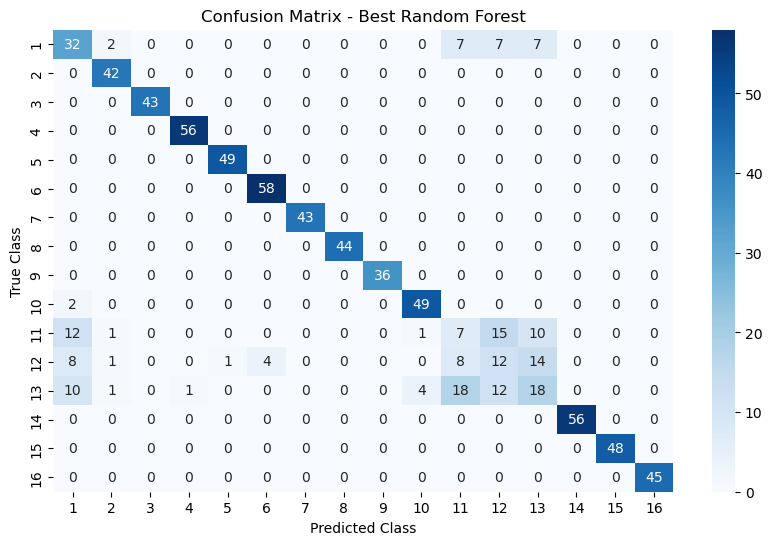

In [32]:
from sklearn.model_selection import GridSearchCV

# Define the parameter grid for Random Forest
param_grid = {
    'classifier__n_estimators': [50, 100, 200],
    'classifier__max_depth': [None, 10, 20],
    'classifier__min_samples_split': [2, 5, 10]
}

# Set up GridSearchCV with the pipeline
grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='accuracy')

# Fit the grid search to find the best model
grid_search.fit(X_train, y_train)

# Get the best parameters
print("Best Parameters from GridSearchCV:", grid_search.best_params_)

# Evaluate the best model
y_pred_best = grid_search.predict(X_test)
print("Best Model Classification Report:\n", classification_report(y_test, y_pred_best))

# Confusion Matrix for the best model
cm_best = confusion_matrix(y_test, y_pred_best)
plt.figure(figsize=(10, 6))
sns.heatmap(cm_best, annot=True, fmt="d", cmap='Blues', xticklabels=y.unique(), yticklabels=y.unique())
plt.title("Confusion Matrix - Best Random Forest")
plt.xlabel("Predicted Class")
plt.ylabel("True Class")
plt.show()



Logistic Regression Classification Report:
              precision    recall  f1-score   support

           1       0.32      0.40      0.35        55
           2       0.46      0.43      0.44        42
           3       0.96      1.00      0.98        43
           4       0.64      0.88      0.74        56
           5       0.91      1.00      0.95        49
           6       0.79      0.95      0.86        58
           7       0.65      1.00      0.79        43
           8       0.79      1.00      0.88        44
           9       1.00      1.00      1.00        36
          10       0.76      0.75      0.75        51
          11       0.20      0.09      0.12        46
          12       0.39      0.19      0.25        48
          13       0.33      0.05      0.08        64
          14       0.85      1.00      0.92        56
          15       0.94      1.00      0.97        48
          16       0.53      0.62      0.57        45

    accuracy                        

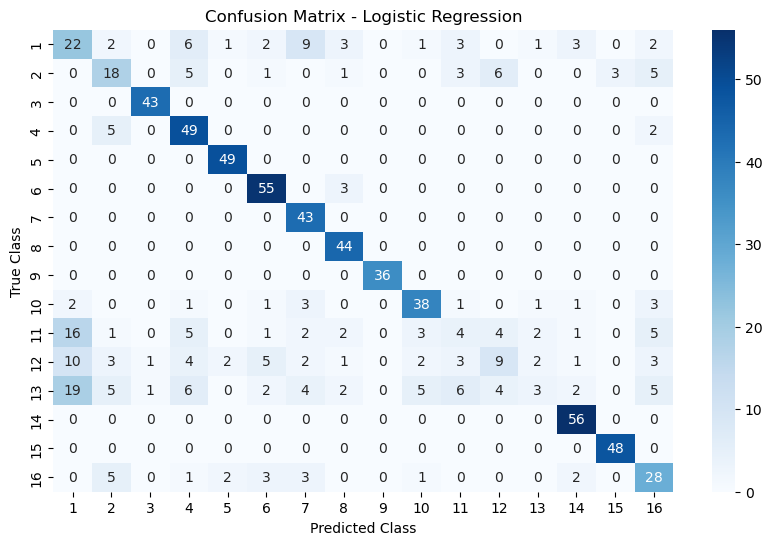


SVM Classification Report:
              precision    recall  f1-score   support

           1       0.28      0.58      0.38        55
           2       0.53      0.69      0.60        42
           3       1.00      1.00      1.00        43
           4       0.84      1.00      0.91        56
           5       0.94      1.00      0.97        49
           6       0.88      1.00      0.94        58
           7       0.88      1.00      0.93        43
           8       0.98      1.00      0.99        44
           9       1.00      1.00      1.00        36
          10       0.78      0.71      0.74        51
          11       0.33      0.11      0.16        46
          12       0.33      0.19      0.24        48
          13       0.15      0.03      0.05        64
          14       0.98      1.00      0.99        56
          15       1.00      1.00      1.00        48
          16       0.62      0.69      0.65        45

    accuracy                           0.74       78

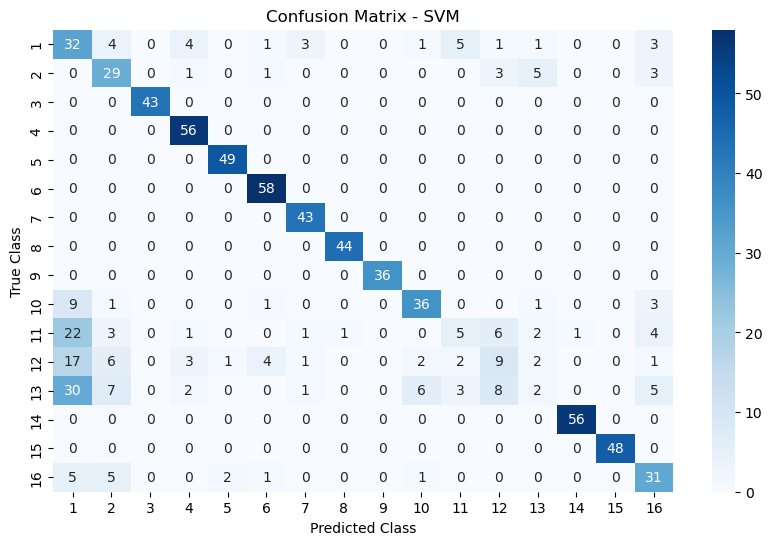

In [33]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

# Define different models to compare
models = {
    'Logistic Regression': LogisticRegression(max_iter=1000),
    'SVM': SVC(kernel='linear', random_state=42)
}

# Evaluate models in a loop
for name, model in models.items():
    pipeline.set_params(classifier=model)
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)
    print(f"\n{name} Classification Report:")
    print(classification_report(y_test, y_pred))

    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(10, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap='Blues', xticklabels=y.unique(), yticklabels=y.unique())
    plt.title(f"Confusion Matrix - {name}")
    plt.xlabel("Predicted Class")
    plt.ylabel("True Class")
    plt.show()


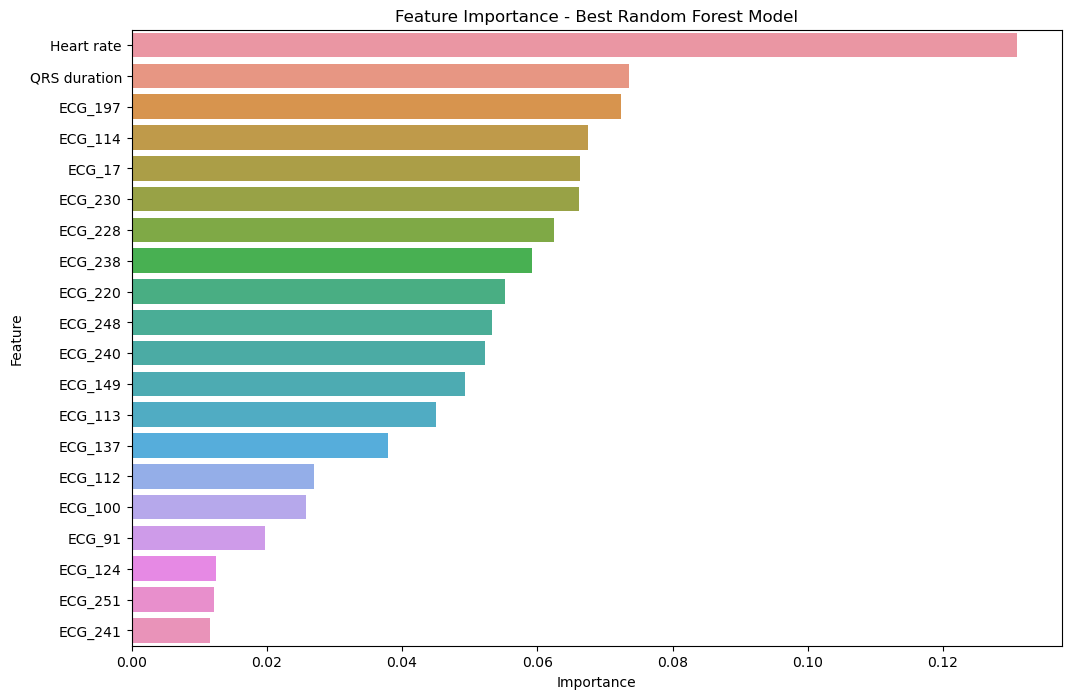

In [34]:
# Get the feature importance of the best model
best_model = grid_search.best_estimator_

# Feature importance from the best model
importances = best_model.named_steps['classifier'].feature_importances_

# Create a DataFrame to view feature importance
feature_importance_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': importances
})

# Sort the DataFrame by importance
feature_importance_df = feature_importance_df.sort_values(by="Importance", ascending=False)

# Plotting the feature importance
plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df)
plt.title("Feature Importance - Best Random Forest Model")
plt.show()


In [35]:
import joblib

# Save the trained model
joblib.dump(grid_search.best_estimator_, 'random_forest_model.pkl')

['random_forest_model.pkl']

In [36]:
# Load the saved model
model = joblib.load('random_forest_model.pkl')


In [37]:
(df_selected.sample())

,QRS duration,Heart rate,ECG_17,ECG_91,ECG_100,ECG_112,ECG_113,ECG_114,ECG_124,ECG_137,...,ECG_197,ECG_220,ECG_228,ECG_230,ECG_238,ECG_240,ECG_241,ECG_248,ECG_251,Class
137,96.0,78.0,44.0,0.0,0.0,0.0,40.0,48.0,0.0,48.0,...,-1.0,0.0,-19.0,-0.1,-17.6,1.1,0.0,-18.9,0.0,1


In [38]:
import pandas as pd
import numpy as np

# Define the number of features
selected_features = ['QRS duration', 'Heart rate', 'ECG_17', 'ECG_91', 'ECG_100', 'ECG_112', 'ECG_113', 'ECG_114', 'ECG_124', 'ECG_137', 'ECG_149', 'ECG_197', 'ECG_220', 'ECG_228', 'ECG_230', 'ECG_238', 'ECG_240', 'ECG_241', 'ECG_248', 'ECG_251']

# Generate random data for the features (you can adjust the range as needed)
random_values = np.random.randn(1, len(selected_features))  # 1 row, with random values (normal distribution)
new_data = pd.DataFrame(random_values, columns=selected_features)

# Display the new_data DataFrame with random values
print(new_data)

# Assuming the model is loaded, predict using the generated random data
predictions = model.predict(new_data)
print(predictions)


   QRS duration  Heart rate    ECG_17    ECG_91   ECG_100   ECG_112   ECG_113  \
0      0.526182   -0.825842 -1.007651  1.334453  0.835725  0.466633  0.010061   

    ECG_114   ECG_124   ECG_137   ECG_149  ECG_197   ECG_220   ECG_228  \
0  1.317428  0.265675  0.156527 -0.099835  2.16019  0.722703  0.809856   

    ECG_230   ECG_238   ECG_240   ECG_241  ECG_248   ECG_251  
0 -1.570539  0.142961  0.943364 -0.627433 -1.53779 -0.630209  
[2]
